In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install wandb

In [3]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [4]:
import supervision as sv

#
# download dataset with a few labelled images (5-10 is recommended, but you can go as high as you like)
#
from roboflow import login,Roboflow

login()
rf = Roboflow()

%cd datasets/
project = rf.workspace("roboflow-4rfmv").project("climbing-y56wy")
dataset = project.version(5).download("coco-segmentation")

climbing_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/train",
    annotations_path=f"{dataset.location}/train/_annotations.coco.json",
    force_masks=True
)

valid_dataset = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/valid",
    annotations_path=f"{dataset.location}/valid/_annotations.coco.json",
    force_masks=True
)

%cd ..

You are already logged into Roboflow. To make a different login, run roboflow.login(force=True).
/home/andrewhealey/sam-fine-tuning/datasets
loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to Climbing-5 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2804.82it/s]


/home/andrewhealey/sam-fine-tuning


In [24]:
# intersect image names from valid with image names from train

valid_imgs = set(key.split(".rf")[0] for key in valid_dataset.images.keys())
train_imgs = set(key.split(".rf")[0] for key in climbing_dataset.images.keys())

valid_imgs.intersection(train_imgs)

set()

In [5]:
from persam.load import load_predictor

predictor = load_predictor("vit_t")

from fine_tune.samed import LoRA_Mask_Decoder

# lora_mask_decoder = LoRA_Mask_Decoder(predictor.model.mask_decoder,r=16)
# mask_decoder = lora_mask_decoder.mask_decoder.cuda()
mask_decoder = predictor.model.mask_decoder

# import torch
# state_dict = torch.load("mask_decoder.pt")
# mask_decoder.load_state_dict(state_dict)

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [6]:
from fine_tune.common import SamBoxDataset, SamPointDataset, SamNextMaskDataset, RandomPointDataset, SamSemSegDataset, get_max_iou_masks

import torch
device = torch.device('cuda:0')

from torch.utils.data import ConcatDataset

# rand_point_dataset = RandomPointDataset(climbing_dataset, predictor, device, points_per_img = 40)
# point_dataset = SamPointDataset(climbing_dataset, predictor, device, points_per_mask = 1)
# box_dataset = SamBoxDataset(climbing_dataset, predictor,device)

# combo_dataset = ConcatDataset([rand_point_dataset, point_dataset])

# print("next mask dataset")
# secondary_rand = RandomPointDataset(climbing_dataset, predictor, device, points_per_img = 40, top_k=None)
# next_rand_point_dataset = SamNextMaskDataset(climbing_dataset,predictor,device,secondary_prompter=secondary_rand)
# print("next point dataset")
# next_point_dataset = SamNextMaskDataset(climbing_dataset,predictor,device,secondary_prompter=point_dataset)

# next_dataset = SamNextMaskDataset(climbing_dataset,predictor,device)

# next_combo_dataset = ConcatDataset([
#     next_rand_point_dataset, next_point_dataset,
#     rand_point_dataset, point_dataset,
#     next_dataset
# ])

In [15]:
from fine_tune.common import SamSemSegDataset
sem_seg_dataset = SamSemSegDataset(climbing_dataset,predictor,device)
valid_sem_seg_dataset = SamSemSegDataset(climbing_dataset,predictor,device)

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 31/31 [00:00<00:00, 105.01it/s]


In [8]:
# valid_point_dataset = SamPointDataset(valid_dataset, predictor, device, points_per_mask=1)
# valid_next_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_point_dataset)

# valid_rand_point_dataset = RandomPointDataset(valid_dataset, predictor, device, points_per_img=100, top_k=None)
# valid_next_rand_point_dataset = SamNextMaskDataset(valid_dataset, predictor, device, secondary_prompter=valid_rand_point_dataset)

In [9]:
# valid_curr_dataset = ConcatDataset([
#     valid_next_rand_point_dataset,valid_next_point_dataset,
#     valid_point_dataset,valid_rand_point_dataset
# ])

In [10]:
# len(rand_point_dataset),len(point_dataset)

In [11]:
from fine_tune.common import SamDataset

In [12]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR
from timm.optim import AdamW

# Define your model and other necessary components here

# Hyperparameters
initial_lr = 2e-4
warmup_steps = 25000
total_steps = 150_000
batch_size = 30 # perform gradient accumulation for this--they do 256 images per batch.
weight_decay = 0.1

lr_decay_steps = [2/3., 0.95]
lr_decay_steps = [int(total_steps * step) for step in lr_decay_steps]

lr_decay_factor = 0.1

optimizer = optim.AdamW(predictor.model.mask_decoder.parameters(), lr=initial_lr, betas=(0.9, 0.999), weight_decay=weight_decay) # criterion = torch.nn.CrossEntropyLoss()

# Learning rate warmup schedule
def warmup_lambda(current_step):
    if current_step < warmup_steps:
        return float(current_step) / float(max(1, warmup_steps))
    return 1.0

warmup_scheduler = LambdaLR(optimizer, lr_lambda=warmup_lambda)

# Step-wise learning rate decay schedule
def lr_decay_lambda(current_step):
    if current_step in lr_decay_steps:
        return lr_decay_factor
    return 1.0

lr_decay_scheduler = LambdaLR(optimizer, lr_lambda=lr_decay_lambda)

In [16]:
curr_dataset = sem_seg_dataset
valid_curr_dataset = valid_sem_seg_dataset
run_grad = True

In [ ]:
import torch
from torch import nn
import cv2
from torch.nn.functional import threshold, normalize
from numpy.random import permutation
from tqdm import tqdm

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from torch.nn import functional as F
import json

log_period = 200 # a few batches
wandb_log_period = 20

# lr = 1e-5
# optimizer = torch.optim.Adam(predictor.model.mask_decoder.parameters(), lr=lr)

run = wandb.init(
    # Set the project where this run will be logged
    project="sam-fine-tune",
    # Track hyperparameters and run metadata
    config={
        "learning_rate": initial_lr,
        "iters": total_steps,
        "batch_size": batch_size,
        "lr_decay_steps": json.dumps(lr_decay_steps),
    })


loss_fn = nn.MSELoss()

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []
recent_mses = []

# iter through dataset in random order

while curr_iters < total_steps:
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):
        curr_iters += 1

        decoder_input, gt_masks, (input_size,original_size), img = curr_dataset[idx]

        _,H,W = gt_masks.shape

        low_res_masks, iou_predictions = mask_decoder(**decoder_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
        binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[0,:,:,:]

        gt_binary_mask, binary_mask, iou, pred_idx = get_max_iou_masks(gt_masks,binary_masks)
        pred_iou = iou_predictions[0,pred_idx]
        pred_mask = high_res_masks[pred_idx]

        assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
        h,w = gt_binary_mask.shape


        flat_pred_mask = pred_mask.view(1,-1)
        flat_gt_binary_mask = gt_binary_mask.view(1,-1)

        focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
        dice_loss = calculate_dice_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)

        # mse loss between predicted and real IoU
        mse_loss = loss_fn(pred_iou, iou)

        loss = 20*focal_loss + dice_loss + mse_loss

        recent_losses += [loss.item()]
        recent_losses = recent_losses[-log_period:]

        if i % wandb_log_period == 0:
            wandb.log({
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
            })

        if i % log_period == 0:
            print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

        if not run_grad: continue
        accumulated_loss += loss
        if curr_iters % batch_size == 0:
            optimizer.zero_grad()
            accumulated_loss /= batch_size
            accumulated_loss.backward()
            optimizer.step()
            accumulated_loss = 0
        
        warmup_scheduler.step(curr_iters)

        # Set learning rate for the step-wise decay phase
        lr_decay_scheduler.step(curr_iters)


In [29]:
torch.save(mask_decoder.state_dict(), 'mask_decoder_11.pt')

In [ ]:
# lora_mask_decoder.save_lora_parameters("lora.pt")
# lora_mask_decoder.load_lora_parameters("lora.pt")

In [27]:
from supervision import DetectionDataset,Detections

test_dataset = DetectionDataset(
    classes=['testing'],
    images={
        'test.jpg':cv2.imread('test.jpg')
    },
    annotations={
        'test.jpg':Detections.empty()
    }
)

test_sem_seg_dataset = SamSemSegDataset(test_dataset,predictor,device)
valid_curr_dataset = test_sem_seg_dataset

100%|██████████| 1/1 [00:00<00:00, 1668.38it/s]


0
one mask
Loss: 7.7411, Focal Loss: 6.7411, Dice Loss: 1.0000, IoU Loss: 1.0000


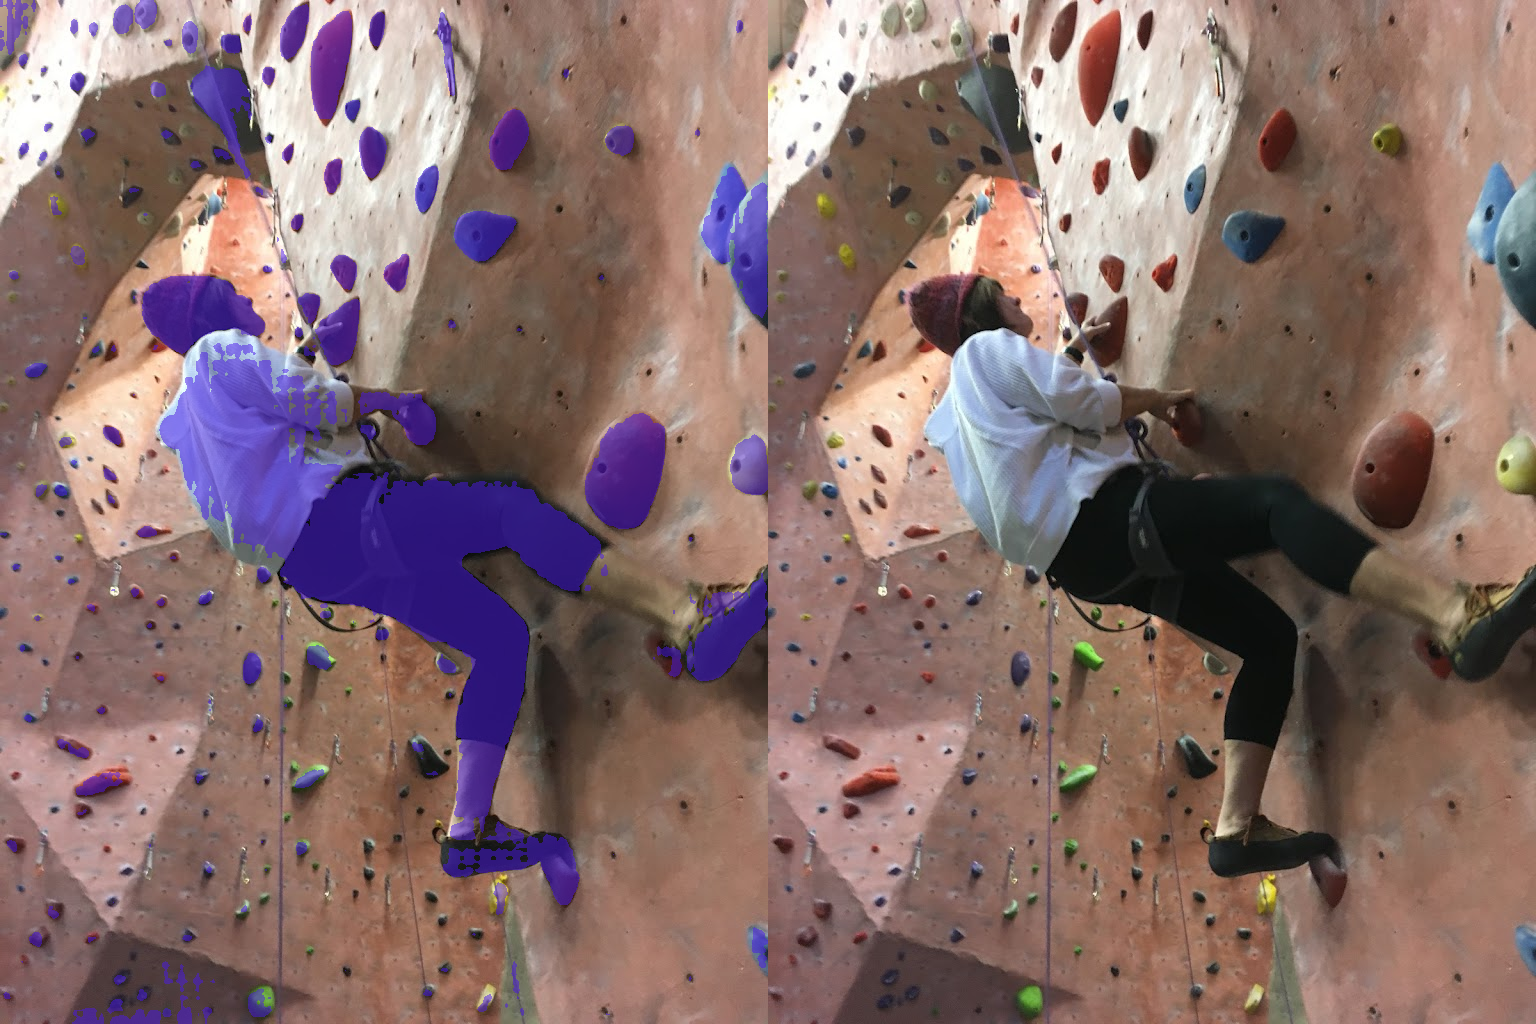

In [28]:
from random import randint
idx = randint(0,len(valid_curr_dataset)-1)
print(idx)

decoder_input, gt_masks, (input_size,original_size), img = valid_curr_dataset[idx]
print("one mask" if len(gt_masks) == 1 else "multiple masks")
low_res_masks, iou_predictions = mask_decoder(**decoder_input)

upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).to(device)
binary_masks = normalize(threshold(upscaled_masks + 0.1, 0.0, 0)).to(device)[0,:,:,:]

# gt_binary_mask = torch.from_numpy(det_mask.astype(np.float32)).to(device)
# gt_binary_mask = get_gt_mask(gt_mask,gt_masks,binary_mask)
gt_binary_mask, binary_mask,*_ = get_max_iou_masks(gt_masks,binary_masks)

binary_mask = binary_masks[torch.argmax(iou_predictions).item()]

# binary_mask = binary_masks[0]
from PIL import Image
import numpy as np

from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

with torch.no_grad():
    flat_binary_mask = binary_mask.view(1,-1)
    flat_gt_binary_mask = gt_binary_mask.view(1,-1)

    focal_loss = calculate_sigmoid_focal_loss(flat_binary_mask, flat_gt_binary_mask,should_sigmoid=False)
    dice_loss = calculate_dice_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    iou_loss = calculate_iou_loss(flat_binary_mask, flat_gt_binary_mask, should_sigmoid=False)
    loss = focal_loss + dice_loss
    print(f"Loss: {loss:.4f}, Focal Loss: {focal_loss:.4f}, Dice Loss: {dice_loss:.4f}, IoU Loss: {iou_loss:.4f}")

from supervision import Detections,MaskAnnotator
from supervision.detection.utils import mask_to_xyxy

annotator = MaskAnnotator()
def mask_to_img(mask,img):
    mask = mask.cpu().detach().numpy()[None,:,:]
    dets = Detections(
        mask=mask,
        xyxy=mask_to_xyxy(mask),
    )
    ann_img = annotator.annotate(scene=img,detections=dets)
    return Image.fromarray(ann_img).convert('RGB')
    return Image.fromarray(img * mask.logical_not().cpu().detach().numpy().astype(np.uint8)[:,:,None]).convert('RGB')
    return Image.fromarray(mask.cpu().detach().numpy().astype(float) * 255).convert('RGB')

def clip_together_imgs(img1,img2):
    return Image.fromarray(np.hstack((img1,img2))).convert('RGB')

clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img))


In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.1)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
masks torch.bool
Mask threshold: 0.0, offset: 1.0, max: True
Intersections: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0', dtype=torch.int32)
Masks: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')
Unions: tensor([409600, 40

NotImplementedError: TODO: fix this

torch.Size([192, 640, 640]) torch.bool


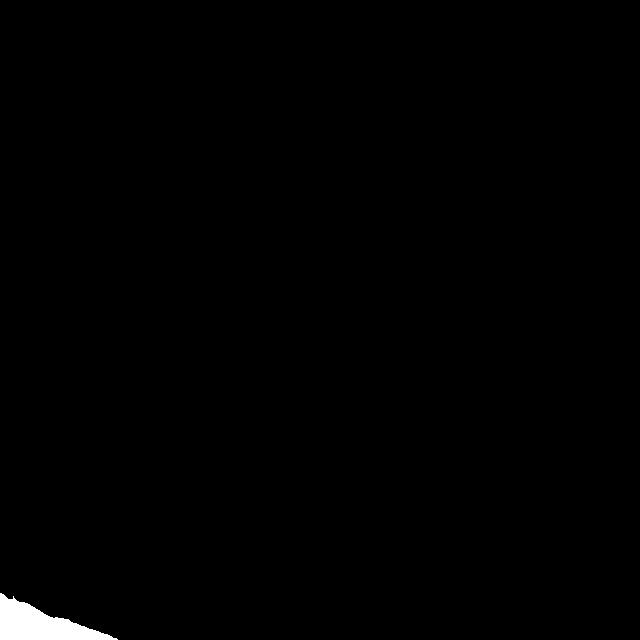

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(climbing_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

[]

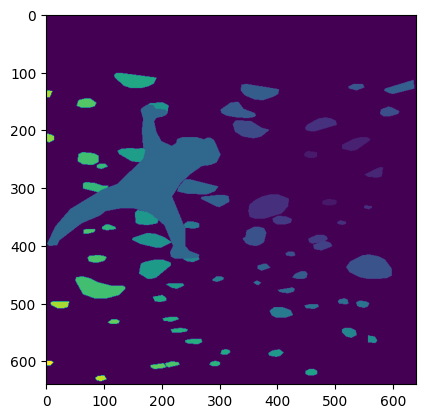

In [ ]:
from supervision.dataset.utils import approximate_mask_with_polygons

from random import choice
rand_img_name = choice(list(climbing_dataset.images.keys()))

rand_img_dets = climbing_dataset.annotations[rand_img_name]

biggest_mask = rand_img_dets.mask[rand_img_dets.area.argmax()]

from supervision.dataset.utils import approximate_mask_with_polygons
def dets_to_polygonss(dets):
    polygons = []
    for _,det_mask,*_ in dets:
        polygons.append(approximate_mask_with_polygons(det_mask))
    return polygons

def get_distances(point, polygonss):
    distances = np.zeros(len(polygonss), dtype=np.float32)
    for i,polygons in enumerate(polygonss):
        distances[i] = min([-cv2.pointPolygonTest(polygon, point, True) for polygon in polygons])
    
    distances = np.maximum(distances, 0)
    return distances

def show_closest_distances(point, dets):
    # get the distance of each det
    polygonss = dets_to_polygonss(dets)
    distances = get_distances(point, polygonss)

    # render the masks with their respective distances

    empty_map = np.zeros_like(dets.mask[0], dtype=np.float32)

    for i,(_,det_mask,*_) in enumerate(dets):
        empty_map[det_mask] = distances[i]

    return empty_map

polygons = approximate_mask_with_polygons(biggest_mask)

# make a signed distance map

empty_map = np.zeros(biggest_mask.shape, dtype=np.float32)

for i in range(biggest_mask.shape[0]):
    for j in range(biggest_mask.shape[1]):
        redPoint = (j,i)
        closestDist = cv2.pointPolygonTest(polygons[0], redPoint, True)

        empty_map[i, j] = -closestDist

empty_map = np.maximum(empty_map, 0)

from matplotlib import pyplot as plt

# plt.imshow(empty_map)

rand_point = (choice(range(biggest_mask.shape[0])), choice(range(biggest_mask.shape[1])))

plt.imshow(show_closest_distances(rand_point, rand_img_dets))